In [47]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from radis import calc_spectrum
from scipy import signal, stats

In [48]:
s = calc_spectrum(wavenum_min=2600, 
                  wavenum_max=3100,  # cm-1
                  cutoff=1e-25,
                  molecule='HCl',
                  isotope='1',
                  pressure=2,           # bar
                  Tgas=298,             # K
                  mole_fraction=0.9,
                  path_length=5,       # cm
                  )
s.apply_slit(1, 'nm')       # simulate an experimental slit

Using cache file: /Users/mskblackbelt/.astropy/cache/astroquery/Hitran/tempfile_HCl_1_2595.00_3105.01.h5
Calculating Equilibrium Spectrum
Physical Conditions
----------------------------------------
   Tgas                 298 K
   Trot                 298 K
   Tvib                 298 K
   isotope              1
   mole_fraction        0.9
   molecule             HCl
   path_length          5 cm
   pressure_mbar        2000.0 mbar
   rot_distribution     boltzmann
   self_absorption      True
   state                X
   vib_distribution     boltzmann
   wavenum_max          3100.0000 cm-1
   wavenum_min          2600.0000 cm-1
Computation Parameters
----------------------------------------
   Tref                 296 K
   broadening_max_width  10 cm-1
   cutoff               1e-25 cm-1/(#.cm-2)
   dbformat             hitran
   dbpath               fetched from astroquery
   dlm_res_G            0.01
   dlm_res_L            0.01
   include_neighbouring_lines  True
   parfuncfmt      

/Users/mskblackbelt/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/radis/misc/warning.py:242: MissingSelfBroadeningWarning: Self-broadening temperature coefficient Tdpsel not given in database: used Tdpair instead
  warnings.warn(WarningType(message))


Spectrum calculated in 1.48s


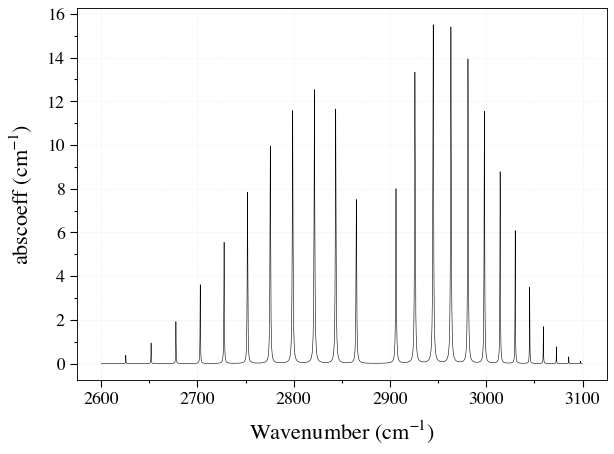

In [49]:
s.plot('abscoeff')

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Import speed_of_light, Planck, and Boltzmann constants
from scipy.constants import c, h, k, e
B_e = 10.59341
alpha_e = 0.30718
D_J = 5.3149e-4
weXe = 52.8186
w_e = 2990.946

peak_width=0.5

%matplotlib inline

In [60]:
v_max, j_max = 5, 21
v_vals = np.arange(v_max)
j_vals = np.arange(j_max)
temp = 298

In [61]:
def rotEnergy(v, J):
    return h * c * 100 * (B_e * J * (J + 1) - alpha_e * (v + 1/2) * J * (J + 1)\
                        - D_J * J**2 * (J + 1)**2)

def rovibEnergy(v, J):
    return h * c * 100 * (w_e * (v + 1/2) - weXe * (v + 1/2)**2 \
                        + B_e * J * (J + 1) - D_J * J**2 * (J + 1)**2 \
                        - alpha_e * (v + 1/2) * J * (J + 1))

def delE_Rbranch(J): 
    return rovibEnergy(1, (J + 1)) - rovibEnergy(0, J)

def delE_Pbranch(J): 
    return rovibEnergy(1, (J - 1)) - rovibEnergy(0, J)

def Qrot(v, temp=temp):
    return np.sum((2 * j_vals + 1) * np.exp(-rotEnergy(v, j_vals) / (k * temp)))
  
def pop(v, J, temp=temp):
    return np.exp(-rotEnergy(v, J) / (k * temp)) / Qrot(v, temp)


In [62]:
Qrot(0, 298)

20.216506424204475

In [63]:
print(rotEnergy(0, j_vals)/(h*c*100))

[   0.           20.87751404   62.61978636  125.20130544  208.583804
  312.716259    437.53489164  582.96316736  748.91179584  935.278731
 1141.949171   1368.79555824 1615.67757936 1882.44216524 2168.923491
 2474.942976   2800.30928384 3144.81832236 3508.25324364 3890.384444
 4290.969564  ]


8247


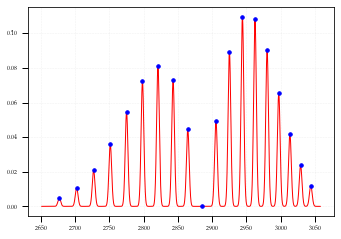

In [64]:
def vibrot_wn(v, J):
    return (w_e * (v + 1/2) - weXe * (v + 1/2)**2 \
            + B_e * J * (J + 1) - D_J * J**2 * (J + 1)**2 \
            - alpha_e * (v + 1/2) * J * (J + 1))

def Pbranch_vals(v, J, temp=temp):
    return vibrot_wn((v + 1), (J - 1)) - vibrot_wn(v, J)

def Rbranch_vals(v, J, temp=temp):
    return vibrot_wn((v + 1), (J + 1)) - vibrot_wn(v, J)

from scipy import signal


def wn_vals(temp=298, v=0, step=0.1):
    return np.arange(Pbranch_vals(v, np.arange(j_max+1), temp).min(), 
                     Rbranch_vals(v, np.arange(j_max), temp).max(), 
                     step)


def Pbranch_spectrum(v, temp=temp):
    peaks = []
    j_vals = np.arange(1, j_max, 1)
    for n in range(len(j_vals)):
         peaks.append((j_vals[n]) * pop(v, j_vals[n], temp) \
             * stats.norm.pdf(wn_vals(temp), 
                              loc=Pbranch_vals(v, j_vals[n], temp), 
                              scale=peak_width) * np.sqrt(2 * np.pi) * peak_width)
            
    return np.sum(peaks, axis=0)

def Rbranch_spectrum(v, temp=temp):
    peaks = []
    j_vals = np.arange(0, j_max-1, 1)
    for n in range(len(j_vals)):
         peaks.append((j_vals[n]+1) * pop(v, j_vals[n], temp) \
             * stats.norm.pdf(wn_vals(temp), 
                              loc=Rbranch_vals(v, j_vals[n], temp), 
                              scale=peak_width) * np.sqrt(2 * np.pi) * peak_width)
    
    return np.sum(peaks, axis=0)

print(len(signal.resample(pop(0,np.arange(j_max),298), len(wn_vals(298)))))
# plt.plot(signal.resample(pop(0,j_vals,298)*Pbranch_vals(0, j_vals, 298), len(wn_vals(298), )),'b.')

j_max = 10
peak_width=2

plt.plot(wn_vals(298), 
         np.sum([Pbranch_spectrum(0,298), Rbranch_spectrum(0,298)], axis=0), 
         'r-', 
         np.concatenate((Rbranch_vals(0,j_vals[:9], 298), Pbranch_vals(0, j_vals[:10], 298))), 
         np.concatenate((((j_vals[:9]+1) * pop(0, j_vals[:9], temp)),((j_vals[:10]) * pop(0, j_vals[:10], temp)))), 
         'b.' 
        )

In [66]:
leveldiagram_lines = []
for v in range(2): 
    leveldiagram_lines.append([])
    for J in range(10):
        leveldiagram_lines[v].append(rovibEnergy(v, J) / e)
        
leveldiagram_lines

[[0.18377785323765233,
  0.18636633508117958,
  0.19154171725555516,
  0.199300836735421,
  0.2096389489827401,
  0.2225497279467964,
  0.23802526606419488,
  0.2560560742588615,
  0.2766310819420432,
  0.2997376370123081],
 [0.5415105520379112,
  0.5440228629492891,
  0.5490459032593658,
  0.5565765099427835,
  0.5666099384615048,
  0.5791398627648141,
  0.5941583752893159,
  0.6116559869589367,
  0.631621627184923,
  0.654042643865843]]

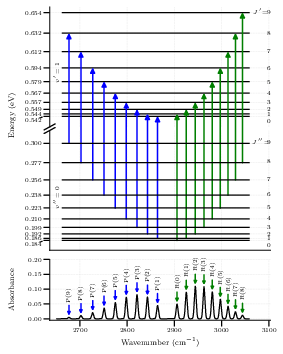

In [86]:
from matplotlib import gridspec
from matplotlib.patches import ConnectionPatch
mpl.use("pgf")
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.serif': ['STIX Two Text', 'Palatino'],
    'text.usetex': True,
    'pgf.rcfonts': False,
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
})

plotted_js = np.arange(10)
(xmin, xmax) = (wn_vals(298).min()-15, wn_vals(298).max()+45)


# Set up canvas
fig = plt.figure(figsize=(4.318,6))

gs0 = gridspec.GridSpec(2, 1, figure=fig, hspace=0.06, height_ratios=[4,1])

gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0], hspace=0.03)
ax_lvl1 = fig.add_subplot(gs00[0])
ax_lvl0 = fig.add_subplot(gs00[1])

gs01 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1])
ax_spec = fig.add_subplot(gs01[0])


# Plot energy level diagrams
for v, ax in [(0, ax_lvl0), (1, ax_lvl1)]:
    ax.hlines(rovibEnergy(v, plotted_js) / e, Pbranch_vals(0,9)-15, Rbranch_vals(0,8)+15)
    ax.set_xlim(xmin,xmax)

ax_lvl1.set_ylim(.53, .66) 
ax_lvl0.set_ylim(.172, .315)

# Create break lines between level plots
d = 0.025
kwargs = dict(transform=ax_lvl1.transAxes, color='k', clip_on=False)
ax_lvl1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

kwargs.update(transform=ax_lvl0.transAxes)  # switch to the bottom axes
ax_lvl0.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

# Remove ticks and spines various subplots
for ax in [ax_lvl0, ax_lvl1, ax_spec]:
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
        
ax_lvl1.spines['bottom'].set_visible(False)

xtick_params = dict(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
    )
ax_lvl1.tick_params(**xtick_params) 
ax_lvl0.tick_params(**xtick_params)
ax_lvl0.tick_params(pad=2)
ax_lvl1.tick_params(pad=2)


## Annotate energy level diagrams
# Create list of level energies as formatted strings
energies = [[""], [""]]
levels = [[],[]]
for v in [0,1]:
    levels[v] = np.arange(j_max)
    for j in leveldiagram_lines[v][1:]:
        energies[v].append(f'{j:0.3f}')
    
# Apply labels for level energies
for v, ax in [(0, ax_lvl0), (1, ax_lvl1)]:
    ax.set_yticks(ticks=leveldiagram_lines[v])
    ax.set_yticklabels(energies[v])
    ax.annotate(f'{leveldiagram_lines[v][0]:0.3f}', 
                xy=(wn_vals(298).min()-27,leveldiagram_lines[v][0]), 
                xytext=(-19,-2),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-',fc='k', ec='k',shrinkA=0),
                fontsize=6,
                annotation_clip=False,
                verticalalignment='top',
                bbox=dict(boxstyle='square,pad=-0.1', fc='w', ec='w'))


# Annotate J level values
jlbl_kwargs = dict(fontsize=6)

for v, ax, scale in [(0, ax_lvl0, 1.015), (1, ax_lvl1, 1.005)]:
    ax.text(3095,leveldiagram_lines[v][0]*scale-.01, 
                 str(levels[v][0]), 
                 **jlbl_kwargs)
    for j in levels[v][1:]:
        ax.text(3095,leveldiagram_lines[v][j]*scale-.005, 
                str(levels[v][j]), 
                **jlbl_kwargs)
    
ax_lvl0.text(3064,leveldiagram_lines[0][9]*1.015-.005,
            r"$J\,''\!=$", **jlbl_kwargs)
ax_lvl1.text(3066,leveldiagram_lines[1][9]*1.005-.005,
            r"$J\,'\!=$", **jlbl_kwargs)


## Create transition arrows between vibrational levels
# Set arguments for transition arrow styles
trans_kwargs = dict(coordsA="data", 
                    coordsB="data",
                    axesA=ax_lvl0, axesB=ax_lvl1,
                    arrowstyle='-|>', linewidth=1.25)

# Create P branch transitions
for j in levels[0][1:]:
    x = Pbranch_vals(0,j)
    con = ConnectionPatch(xyA=(x, leveldiagram_lines[0][j]), 
                          xyB=(x, leveldiagram_lines[1][j-1]), 
                          fc='b', ec='b', **trans_kwargs)
    ax_lvl0.add_artist(con)
    
# Create R branch transitions
for j in levels[1][:-1]:
    x = Rbranch_vals(0,j)
    con = ConnectionPatch(xyA=(x, leveldiagram_lines[0][j]), 
                          xyB=(x, leveldiagram_lines[1][j+1]), 
                          fc='g', ec='g', **trans_kwargs)
    ax_lvl0.add_artist(con)

# Label v manifolds
ax_lvl0.text(2645,leveldiagram_lines[0][5],
            r"$v\,''\!=0$",rotation='vertical',
            fontsize=6)
ax_lvl1.text(2645,leveldiagram_lines[1][5],
            r"$v\,'\!=1$",rotation='vertical',
            fontsize=6)

# Label y-axis for level diagram
fig.text(0.05, 0.6, r'Energy (eV)', 
         rotation='vertical', ha='center', va='center',
         fontsize=8)

# Plot spectrum
ax_spec.plot(wn_vals(298), 
             np.sum([Pbranch_spectrum(0,298), Rbranch_spectrum(0,298)], axis=0), 
             'k-')
ax_spec.set_ylim(-.005,0.2)
ax_spec.set_xlim(xmin,xmax)
ax_spec.set_ylabel(r'Absorbance')
ax_spec.set_xlabel(r'Wavenumber (cm$^{-1}$)')
ax_spec.tick_params(pad=2)
ax_spec.yaxis.set_label_coords(-.16, 0.5)

## Label peaks in spectrum
# Arrow properties
length = .05
shrink = 3
arrow_kwargs = dict(va='bottom', ha='center', rotation='vertical', fontsize=6, 
                    bbox=dict(boxstyle='square,pad=-0.1', fc='w', ec='w'))
for j in levels[0][1:]:
    x, y = Pbranch_vals(0,j), ((j_vals[j]) * pop(0, j_vals[j], 298))
    ax_spec.annotate((f'P({j})'), 
                     xy=(x, y), 
                     xytext=(x, y+length),
                     xycoords='data',
                     textcoords='data',
                     arrowprops=dict(arrowstyle='-|>', linewidth=1.25, shrinkA=shrink,
                                    fc='b', ec='b',),
                     **arrow_kwargs)

for j in levels[1][:-1]:
    x, y = Rbranch_vals(0,j), ((j_vals[j]+1) * pop(0, j_vals[j], 298))
    ax_spec.annotate((f'R({j})'), 
                     xy=(x, y), 
                     xytext=(x, y+length),
                     xycoords='data',
                     textcoords='data',
                     arrowprops=dict(arrowstyle='-|>', linewidth=1.25, shrinkA=shrink,
                                    fc='g', ec='g',),
                     **arrow_kwargs)
    
plt.savefig("./vibrot_energy_diagram.pgf")